# Annual Extremes

1. Obtain hourly and daily mean tide gauge data from UHSLC
2. Deconstruct the time series into components with different timescales
3. Get high-pass filtered data:
    1. Remove linear trend
    2. Obtain low-frequency SL variability by smoothing daily data with a running Gaussian-shaped low-pass filter (half power period at ~5 months).
    3. Compute seasonal cycle by averaging daily mean WL over all years for each year day
    4. High-frequency SL is the residual of the daily means after removing #3,#4,#5
4. Tidal component is predicted with fits to hourly data
5. Reference all data to MHHW
6. Extreme events are the superposition of seasonal sea level, tidal and high frequency water level components.
    1. Tidal contribution is 95% exceedence threshold of daily highest water above MHHW on each day.
    2. HF variability is the 95% exceedance threshold of the HF filtered data on each year day.
7. Obtain TWL (H95) by stacking the seasonal sea level, tide contribution, and HF contribution

## Setup
The usual deal.

In [3]:
%run ../setup.ipynb
%run ../plotting_functions.ipynb
data_dir = Path('../../data' )
output_dir = Path('../../output') 
import utide
from scipy.interpolate import interp1d

# check to make sure that data_dir/rsl_daily_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_daily_hawaii.nc').exists():
    print('rsl_daily_hawaii.nc not found in ../../data. Please run the data wrangling notebook first')
else:
    print('rsl_daily_hawaii.nc found in ../../data. Proceed.')


# check to make sure that data_dir/rsl_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_hawaii.nc').exists():
    print('rsl_hawaii.nc not found in ../../data. Please run the data wrangling notebook first')
else:
    print('rsl_hawaii.nc found in ../../data. Proceed.')

rsl_daily_hawaii.nc found in ../../data. Proceed.
rsl_hawaii.nc found in ../../data. Proceed.


## Obtain Daily and Hourly datasets

In [4]:
#import rsl_daily
rsl_daily_all = xr.open_dataset(data_dir/ 'rsl_daily_hawaii.nc')

#make rsl_daily a subset - do not include TGs with more than 25% NaNs
data_coverage = rsl_daily_all['rsl_mhhw'].count(dim='time')/len(rsl_daily_all.time)

#drop all locations with data_coverage less than 80%
rsl_daily = rsl_daily_all.where(data_coverage>0.80,drop=True)

rsl_hourly = xr.open_dataset(data_dir/ 'rsl_hawaii.nc')
rsl_hourly

# # make rsl_hourly have the same time period as rsl_daily
# rsl_hourly = rsl_hourly.sel(time = slice(rsl_daily.time[0], rsl_daily.time[-1]))

#include only the TGs that are in rsl_subset
rsl_hourly = rsl_hourly.sel(record_id = rsl_daily.record_id.values)

## Deconstruct the time series into components with different timescales.

### Get high-pass filtered data
#### Remove linear trend

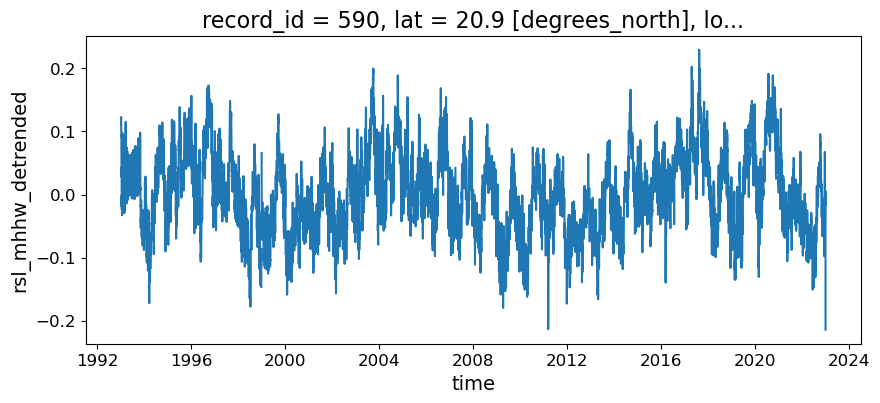

In [5]:
# remove the linear trend from rsl_daily

trend_mag, trend_line, trend_rate = process_trend_with_nan(rsl_daily['rsl_mhhw'])

rsl_daily['rsl_mhhw_detrended'] = rsl_daily['rsl_mhhw'] - trend_line

rsl_daily['rsl_mhhw_detrended'].sel(record_id = 590).plot()

#### Obtain low-frequency SL variability 
We'll do this by smoothing daily data with a running Gaussian-shaped low-pass filter (half power period at ~5 months).

In [6]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import detrend

# Define the filter parameters
half_power_period = 5 * 30  # Approximate number of days in 5 months
sigma = half_power_period / np.sqrt(8 * np.log(2))  # Convert half-power period to standard deviation

# Detrend each station's time series and handle NaNs
rsl_mhhw_detrended = np.empty_like(rsl_daily['rsl_mhhw'].values)

for i in range(rsl_daily['record_id'].size):
    data = rsl_daily['rsl_mhhw'][i, :].values
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    rsl_mhhw_detrended[i, :] = detrend(data)


# Apply the Gaussian filter to the detrended data
rsl_mhhw_detrended_filtered = gaussian_filter1d(rsl_mhhw_detrended, sigma=sigma, axis=1)

# Add the detrended and filtered data to the dataset
rsl_daily['rsl_mhhw_detrended_interp'] = (('record_id', 'time'), rsl_mhhw_detrended)
rsl_daily['rsl_mhhw_detrended_filtered'] = (('record_id', 'time'), rsl_mhhw_detrended_filtered)



#### Compute the seasonal cycle by averaging daily mean water levels over all years for each year day

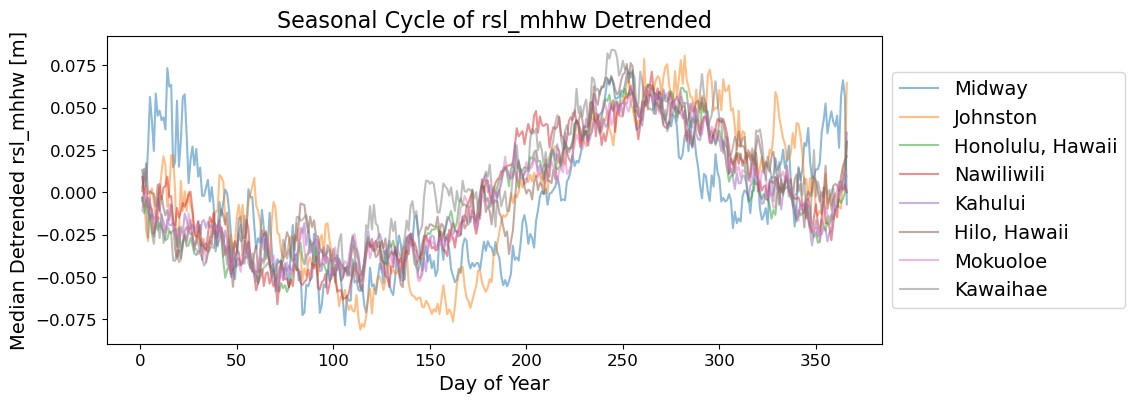

In [7]:
# Compute seasonal cycle by averaging daily rsl_mhhw over all years for each year day
seasonal_cycle = rsl_daily['rsl_mhhw_detrended'].groupby('time.dayofyear').median(dim='time') #NOTE I AM USING MEDIAN!!!

# Plot the seasonal cycle, with 11 different lines, and add the station names to the legend
plt.figure()
for i in range(seasonal_cycle.shape[0]):
    plt.plot(seasonal_cycle['dayofyear'], seasonal_cycle[i, :], label=rsl_daily['station_name'].values[i], alpha=0.5)
plt.xlabel('Day of Year')
plt.ylabel('Median Detrended rsl_mhhw [m]')
plt.title('Seasonal Cycle of rsl_mhhw Detrended')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Obtain High Frequency data
It is the residual of the daily means after removing the linear trend, low-frequency variability, and seasonal cycle.

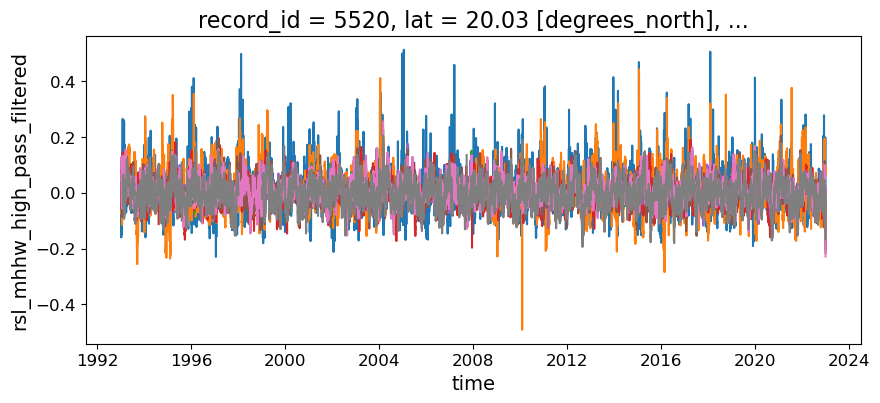

In [8]:
# Extend the seasonal cycle to the full time series length for each station
seasonal_cycle_full = seasonal_cycle.sel(dayofyear=rsl_daily['time'].dt.dayofyear)

# Compute the residual by removing the linear trend, filtered data, and seasonal cycle
residual = rsl_daily['rsl_mhhw_detrended'] - rsl_mhhw_detrended_filtered - seasonal_cycle_full

# Add the residual to the dataset
rsl_daily['rsl_mhhw_high_pass_filtered'] = (('record_id', 'time'), residual.values)

# Plot the residual for each station
plt.figure()
for i in range(rsl_daily['record_id'].size):
    rsl_daily['rsl_mhhw_high_pass_filtered'].sel(record_id=rsl_daily['record_id'][i]).plot(label=rsl_daily['station_name'].values[i])


### Tidal component is predicted with fits to hourly data

In [9]:
# Helper function to split data into continuous segments
def split_continuous_segments(time, data, max_gap_hours=12):
    segments = []
    current_segment = []
    for i in range(len(time) - 1):
        current_segment.append((time[i], data[i]))
        gap = (time[i + 1] - time[i]).total_seconds() / 3600  # Convert gap to hours
        if gap > max_gap_hours:
            segments.append(current_segment)
            current_segment = []
    current_segment.append((time[-1], data[-1]))
    segments.append(current_segment)
    return segments

In [10]:
# convert time in rsl_hourly to fractional year, starting at 0
time = rsl_hourly['time']
time = time - time[0]
time = time/np.timedelta64(1, 'D')
time = time/365.25

In [11]:
# check to make sure that data_dir/rsl_hawaii_tidal_predictions.nc exists, if not, run the following code to create it
if not (data_dir / 'rsl_hawaii_tidal_predictions.nc').exists():
    print('rsl_hawaii_tidal_predictions.nc not found in ../../data. Will proceed with tidal analysis and prediction.')


    # Prepare an empty array to store tidal predictions for all stations
    sea_level_shape = rsl_hourly['sea_level'].shape
    tidal_predictions = np.full(sea_level_shape, np.nan)  # Initialize with NaNs

    # Perform tidal analysis and prediction for each station
    for i, station_id in enumerate(rsl_hourly['record_id'].values):
        sea_level_data = rsl_hourly['sea_level'].sel(record_id=station_id).values
        #remove linear trend
        sea_level_data = sea_level_data - trend_rate.sel(record_id=station_id).values*1000*time

        time_data = rsl_hourly['time'].values
        latitude = rsl_hourly['lat'].sel(record_id=station_id).values

        # Convert time_data to pandas datetime format for UTide
        time_series = pd.to_datetime(time_data)

        # Split data into continuous segments
        segments = split_continuous_segments(time_series, sea_level_data)
    
        # Perform harmonic analysis on each segment
        for segment in segments:
            segment_time, segment_data = zip(*segment)
            segment_time = np.array(segment_time)
            segment_data = np.array(segment_data)
    
            # Convert datetime to numeric format for interpolation
            segment_time_numeric = segment_time.astype('datetime64[s]').astype(np.float64)
    
            # Check for NaNs and interpolate to fill NaNs if needed
            if np.isnan(segment_data).any():
                mask = np.isnan(segment_data)
                interp_func = interp1d(segment_time_numeric[~mask], segment_data[~mask], kind='linear', fill_value="extrapolate")
                segment_data[mask] = interp_func(segment_time_numeric[mask])
    
            # Perform harmonic analysis
            coef = utide.solve(segment_time, segment_data, lat=latitude)
    
            # Predict the tide using the fitted model
            tide_pred = utide.reconstruct(segment_time, coef)
    
            # Store the tidal predictions in the array
            for t, pred in zip(segment_time, tide_pred.h):
                idx = np.where(time_series == t)[0][0]
                tidal_predictions[i, idx] = pred
    
    # Create the tidal predictions xarray Dataset with the same structure as rsl_hourly
    tidal_predictions_ds = xr.Dataset(
        data_vars={'tidal_prediction': (('record_id', 'time'), tidal_predictions)},
        coords={'time': rsl_hourly['time'].values, 'record_id': rsl_hourly['record_id'].values}
    )

    # save rsl_daily_combined to the data directory
    tidal_predictions_ds.to_netcdf(data_dir / 'rsl_hawaii_tidal_predictions.nc')
    print(f'Tidal predictions saved to: {data_dir / "rsl_hawaii_tidal_predictions.nc"}')

else:
    print('rsl_hawaii_tidal_predictions.nc found in ../../data. Proceed.')




rsl_hawaii_tidal_predictions.nc found in ../../data. Proceed.


Reference all data to MHHW

In [12]:
# open rsl_hawaii_tidal_predictions.nc
rsl_hawaii_tidal_predictions = xr.open_dataset(data_dir / 'rsl_hawaii_tidal_predictions.nc')
#

rsl_hawaii_tidal_predictions
#Adjust the tidal precictions to be in MHHW
# for station_id in rsl_hawaii_tidal_predictions.data_vars:
    # rsl_hawaii_tidal_predictions[station_id] = rsl_hawaii_tidal_predictions[station_id] + rsl_hourly['MHHW'].sel(record_id=int(station_id))

<xarray.Dataset> Size: 19MB
Dimensions:           (record_id: 8, time: 262945)
Coordinates:
  * time              (time) datetime64[ns] 2MB 1993-01-01 ... 2022-12-31
  * record_id         (record_id) int16 16B 500 520 570 580 590 600 610 5520
Data variables:
    tidal_prediction  (record_id, time) float64 17MB ...

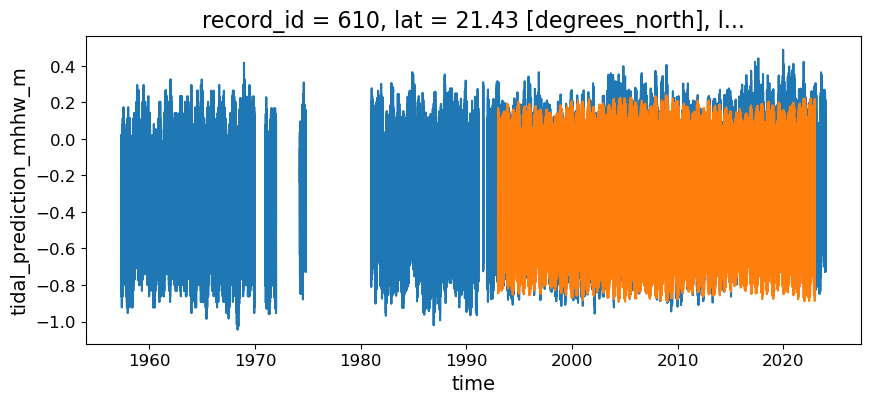

In [13]:
# reference it to MHHW
rsl_hawaii_tidal_predictions['tidal_prediction_mhhw_m'] = 0.001*(rsl_hawaii_tidal_predictions['tidal_prediction'] - rsl_hourly['MHHW'])

#plot the tidal predictions for Honolulu
rid = 6
rsl_hourly['sea_level_mhhw'] = 0.001*(rsl_hourly['sea_level'] - rsl_hourly['MHHW'])
rsl_hourly['sea_level_mhhw'].sel(record_id=rsl_daily.record_id[rid]).plot()
# rsl_daily['rsl_mhhw_detrended_interp'].sel(record_id=rsl_daily.record_id[rid]).plot()
rsl_hawaii_tidal_predictions['tidal_prediction_mhhw_m'].sel(record_id=rsl_daily.record_id[rid]).plot()


#### Find 95% exceedence threshold for tidal component


In [14]:
rsl_daily_max_tidal = rsl_hawaii_tidal_predictions['tidal_prediction_mhhw_m']
# .groupby('time.day').max(dim='time')
#plot
# get daily max tidal prediction by resampling to daily and taking the max
rsl_daily_max_tidal = rsl_daily_max_tidal.resample(time='1D').max(dim='time')



# get 95th percentile of rsl_daily_max_tidal
rsl_daily_max_tidal_95 = rsl_daily_max_tidal.quantile(0.95, dim='time')

rsl_daily_max_tidal_95

/opt/anaconda3/envs/SLI39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<xarray.DataArray 'tidal_prediction_mhhw_m' (record_id: 8)> Size: 64B
array([0.07134963, 0.07089786, 0.1674273 , 0.14561199, 0.22541946,
       0.17487762, 0.14735319,        nan])
Coordinates:
  * record_id  (record_id) int16 16B 500 520 570 580 590 600 610 5520
    quantile   float64 8B 0.95

In [15]:
# get the 95th percentile of the HF residual data
rsl_daily_residual_95 = rsl_daily['rsl_mhhw_high_pass_filtered'].quantile(0.95, dim='time')

rsl_daily_residual_95

<xarray.DataArray 'rsl_mhhw_high_pass_filtered' (record_id: 8)> Size: 64B
array([0.12244663, 0.12557215, 0.06974787, 0.07748165, 0.0683047 ,
       0.07887614, 0.07548355, 0.0763025 ])
Coordinates:
  * record_id     (record_id) int16 16B 500 520 570 580 590 600 610 5520
    lat           (record_id) float32 32B 28.22 16.75 21.31 ... 21.43 20.03
    lon           (record_id) float32 32B 182.6 190.5 202.1 ... 202.2 204.2
    station_name  (record_id) <U17 544B 'Midway' 'Johnston' ... 'Kawaihae'
    quantile      float64 8B 0.95

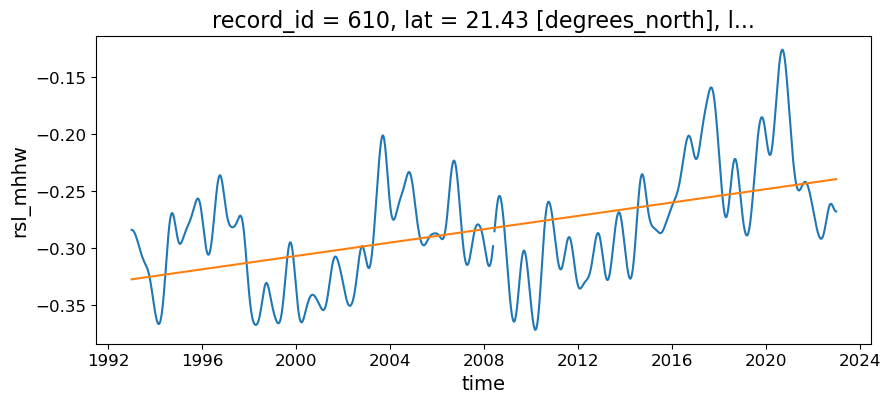

In [16]:
rsl_low_frequency = rsl_daily['rsl_mhhw_detrended_filtered'].sel(record_id=rsl_daily.record_id[rid]) + trend_line.sel(record_id=rsl_daily.record_id[rid])

# plot rsl_low_frequency, trend_line
rsl_low_frequency.plot()
trend_line.sel(record_id=rsl_daily.record_id[rid]).plot()

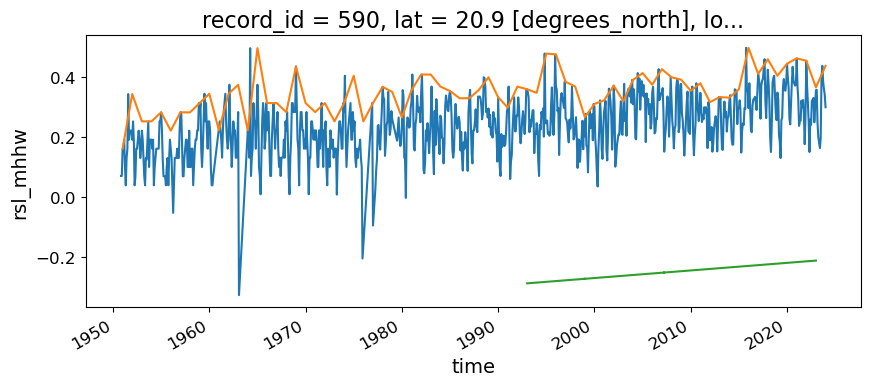

In [50]:
station_id = 590
# Convert to DataFrame for easier handling
time_series = rsl_hourly['time'].values
sea_level_data = rsl_hourly['sea_level'].sel(record_id=station_id).values  # Replace with your station ID

data = pd.DataFrame({
    'time': pd.to_datetime(time_series),
    'sea_level': sea_level_data
})

# Resample to get annual maxima
annual_maxima = data.resample('YE', on='time').max()

# Drop rows with missing values
annual_maxima = annual_maxima.dropna()

# set this with respect to MHHW
annual_maxima['sea_level'] = 0.001*(annual_maxima['sea_level'] - rsl_hourly['MHHW'].sel(record_id=station_id).values)


# add montly maxima
monthly_maxima = data.resample('ME', on='time').max()
monthly_maxima = monthly_maxima.dropna()
monthly_maxima['sea_level'] = 0.001*(monthly_maxima['sea_level'] - rsl_hourly['MHHW'].sel(record_id=station_id).values)

monthly_maxima['sea_level'].plot()
annual_maxima['sea_level'].plot()

# add trend line
trend_line.sel(record_id=station_id).plot()
# plt.scatter(monthly_maxima['time'], monthly_maxima['sea_level'], label='Monthly Maxima')

# plt.scatter(monthly_maxima.index, monthly_maxima['sea_level'], label='Annual Maxima')


In [43]:
monthly_maxima

,sea_level
time,
1950-10-31,69.0
1950-11-30,69.0
1950-12-31,160.0
1951-01-31,160.0
1951-02-28,190.0
...,...
2023-08-31,436.0
2023-09-30,384.0
2023-10-31,359.0


In [59]:
from scipy.stats import genextreme
import pyextremes

#turn sea_level_data into a series

# Convert to DataFrame for easier handling
# Convert 'time' values to numeric format
time_numeric = pd.to_numeric(time_series)

# Calculate the time difference in seconds
time_diff = (time_numeric - time_numeric[0]) / np.timedelta64(1, 'h')

# Update the 'sea_level_data' series with the corrected values
sea_level_data = pd.Series(sea_level_data, index=pd.to_datetime(time_diff, unit='h'))




# # Convert to DataFrame for easier handling
# time_series = rsl_hourly['time'].values
# sea_level_data = rsl_hourly['sea_level'].sel(record_id=station_id).values  # Replace with your station ID

# # turn sea_level_data into a series
# sea_level_data = pd.Series(sea_level_data, index=pd.to_datetime(time_series))
# extremes = pyextremes.get_extremes(data, "BM")





# annual_maxima = pyextremes.get_extremes(ts=sea_level_data, extremes = extremes,method='BM')

# # Fit GEV distribution to annual maxima
# gev_params = genextreme.fit(annual_maxima['sea_level'])

# # Generate return levels for various return periods
# return_periods = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
# return_levels = genextreme.ppf(1 - 1 / return_periods, *gev_params)

# # Calculate exceedance probabilities
# exceedance_probabilities = 1 - genextreme.cdf(annual_maxima['sea_level'], *gev_params)

UFuncTypeError: ufunc 'divide' cannot use operands with types dtype('int64') and dtype('<m8[h]')

In [28]:
gev_params

(5.456905370812795, 494.47985682719286, 8.295269177899938)

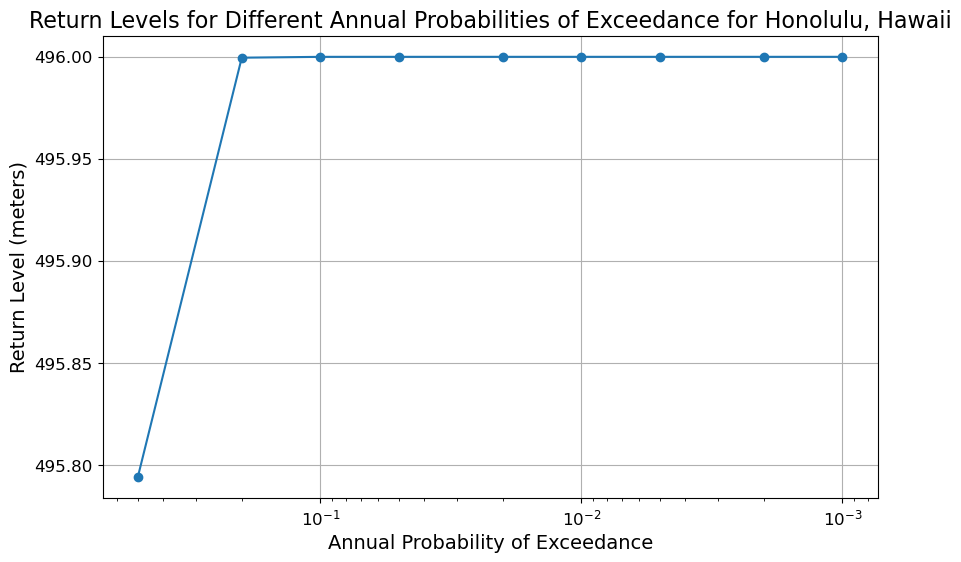

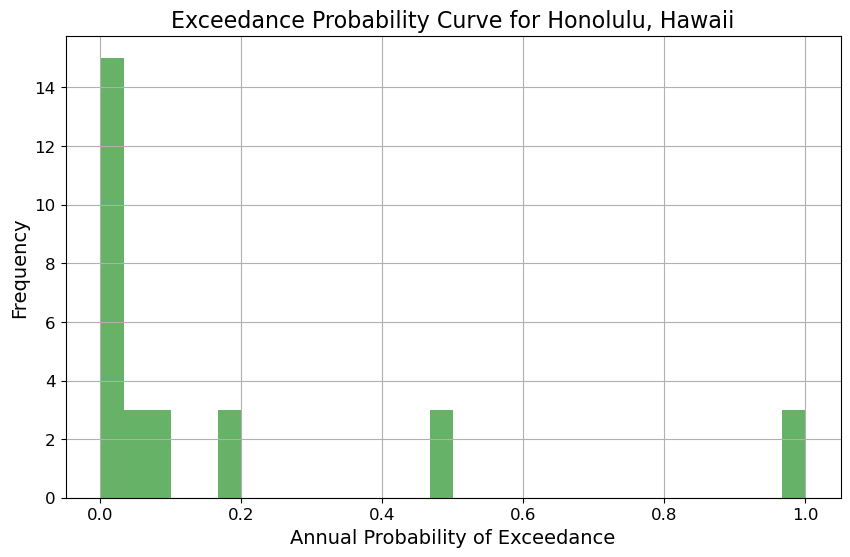

In [31]:
# Calculate annual probability of exceedance
annual_prob_exceedance = 1 / return_periods

# Plot return levels with annual probability of exceedance on x-axis
plt.figure(figsize=(10, 6))
plt.plot(annual_prob_exceedance, return_levels, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Annual Probability of Exceedance')
plt.ylabel('Return Level (meters)')
plt.title('Return Levels for Different Annual Probabilities of Exceedance for Honolulu, Hawaii')
plt.grid(True)
plt.gca().invert_xaxis()  # Invert x-axis to have higher probabilities on the left
plt.show()
